In [40]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import *
import matplotlib.pyplot as plt
#from radiomics.featureextractor import *
from sklearn import mixture
import SimpleITK as sitk

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
from library_dicom.post_processing.WatershedModel import WatershedModel 
from library_dicom.dicom_processor.tools.folders import *
from library_dicom.dicom_processor.tools.threshold_mask import *
from library_dicom.dicom_processor.tools.postprocessing import *
import csv

In [42]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/diff_tmtv_truth_pred.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [43]:
len(csv_data)

404

data = []
for row in csv_data_3 : 
    if float(row[-1]) > 0 : #vol pred plus grand que truth 
        data.append(row)

len(data)

In [5]:
data[0]

['13011101051022',
 '1.2.840.113619.2.290.3.2831165510.988.1366867863.298',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/mot_an_apr 25_2013.csv',
 '504.31',
 '549.0999999999999',
 '44.78999999999991',
 '537.4658309104416',
 '6.574494043433915']

In [44]:
error = []
tmtv = []

for serie in csv_data : 
    print(csv_data.index(serie))
    try : 
        img = sitk.ReadImage(serie[4])
        array = sitk.GetArrayFromImage(img).transpose()

        pet_img = sitk.ReadImage(serie[2])
        pet_array = sitk.GetArrayFromImage(pet_img).transpose()
        spacing = pet_img.GetSpacing()

        volume_voxel = spacing[0]*spacing[1]*spacing[2]*10**(-3)

        array = get_threshold_matrix_4D(array, pet_array, 0.41)

        mask_3d = np.sum(array, axis = -1)

        number_pixel = len(np.where(mask_3d != 0)[0])

        tmtv.append(volume_voxel * number_pixel)

    except Exception as err : 
        print(err)
        error.append(serie)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [45]:
write_json_file('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing', 'tmtv_verite_terrain', tmtv)

In [ ]:
#calcul volume_pred : 
volume_pred = []
for serie in csv_data : 
    print(csv_data.index(serie))

    model = WatershedModel(serie[3], serie[2], '3d')
    binary_img = model.get_binary_threshold_mask_img(0.5)
    binary_array = model.remove_small_roi(binary_img)

    volume_voxel = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2]*10**(-3)
    number_pixel = len(np.where(binary_array != 0)[0])

    volume_pred.append(volume_voxel * number_pixel)


In [ ]:
write_json_file('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing', 'volume_predi', volume_pred)

In [ ]:
#reste à différencier les pred qui ont un tmtv au dessus du tmtv truth, 
#appliquer watershed
#voir résultas 

#va faire pareil avec les preds qui ont un tmtv en dessous du tmtv truth

In [7]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_tmtv_2cm.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_3 = []
    for row in reader :
        csv_data_3.append(row)
        
del csv_data_3[0] #enlever première ligne

In [9]:
tmtv_ws = []
for row in csv_data_3 : 
    tmtv_ws.append(float(row[-4]))


In [10]:
pourcent = []
for i in range(len(tmtv)):
    diff = (abs(tmtv[i] - tmtv_ws[i]) / tmtv[i] ) * 100
    pourcent.append(diff)


In [23]:
cpt = 0
for item in pourcent : 
    if item <= float(20):
        cpt += 1

In [24]:
cpt

110

In [4]:
error_ws = []
tmtv_sous_seg = []

for serie in data : 
    print(data.index(serie))
    try : 
        model = WatershedModel(serie[3], serie[2], type='3d')
        ws_array, num_label = model.watershed_model(0.5)

        volume_voxel = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2]*10**(-3)

        ws_array = get_threshold_matrix(ws_array, model.pet_array, num_label, 0.41)

        number_pixel = len(np.where(ws_array != 0)[0])

        tmtv_sous_seg.append(volume_voxel * number_pixel)



    except Exception as err : 
        print(err)
        error_ws.append(serie)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


In [17]:
#comparer tmtv sous_seg et tmtv seuil a 41% des verités de terrains 
json_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/tmtv_truth_firstpart.json'
tmtv = []
with open(json_path) as json_file : 
    reader = json.load(json_file)
    for info in reader :
        tmtv.append(info)

print(len(tmtv))

199


In [9]:
#comparer tmtv sous seg et tmtv dans les csv à 41%
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_tmtv_2cm.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_1 = []
    for row in reader :
        csv_data_1.append(row)
        
del csv_data_1[0] #enlever première ligne

In [12]:
tmtv_csv = []
for row in csv_data_1 : 
    tmtv_csv.append(float(row[6]))

In [18]:
pourcent = []
for i in range(len(tmtv)):
    diff = (abs(tmtv[i] - tmtv_sous_seg[i]) / tmtv[i]) * 100
    pourcent.append(diff)

In [19]:
cpt = 0
for item in pourcent : 
    if item <= float(20) : 
        cpt += 1

In [20]:
cpt

114

In [ ]:
#calculer diff volume seuil a 41% du mask et predictions sans sous segmentation

In [22]:
vol_pred = []
for row in csv_data_1 : 
    vol_pred.append(float(row[9]))

In [25]:
pourcent_2 = []
for i in range(len(vol_pred)) : 
    diff = ((vol_pred[i] - tmtv[i]) / tmtv[i]) * 100
    pourcent_2.append(diff)

In [28]:
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_tmtv_overseg_v4.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "PRED_MASK", "NIFTI_MASK", "CSV", "VOL_PRED", "VOL_TRUTH", "POURCENT_VOL_DIFF_TRUTH_PRED", "VOL_WS","POURCENT_WS"])
    for serie in data:
        index = data.index(serie)
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], vol_pred[index], tmtv[index], pourcent_2[index], tmtv_sous_seg[index], pourcent[index]])   

In [32]:
#dans ceux qui ont plus de 35% de différence de volume, regarder si le volume prédit est beaucoup plus grand que le tmtv seuillé truth 

csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_tmtv_overseg_v4.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_2 = []
    for row in reader :
        csv_data_2.append(row)
        
del csv_data_2[0] #enlever première ligne

In [33]:
csv_data_2[0]

['13011101051022',
 '1.2.840.113619.2.290.3.2831165510.988.1366867863.298',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/mot_an_apr 25_2013.csv',
 '537.4658309104416',
 '508.29798592676525',
 '5.7383357383357385',
 '422.18805295735365',
 '16.940836940836938']

In [37]:
diff_pred_truth = []
for row in csv_data_2 : 
    if float(row[-1]) >= float(20) : 
        diff_pred_truth.append(float(row[-3]))

In [38]:
len(diff_pred_truth)

85

In [39]:
diff_pred_truth

[98.3252296056186,
 75.0314804821011,
 29.354515528839276,
 72.42864835756595,
 135.11066398390338,
 0.7746933505487419,
 19.509308081351556,
 300.1324152542373,
 51.967324710687556,
 104.04447836040553,
 52.395672333848545,
 163.24431256181998,
 83.41384863123994,
 110.44414535666216,
 4.942861076690069,
 3.7031392868028044,
 3.1027253668763186,
 213.6798679867987,
 2.785782901056676,
 106.87121866897147,
 67.71376345541941,
 137.92004434282546,
 53.70643102601868,
 1.14865989678709,
 11.59974506054812,
 273.38308457711446,
 110.06727828746176,
 3.4042553191489398,
 92.0116539060912,
 30.945872061235658,
 147.71535580524343,
 144.03100775193798,
 23.41559723593287,
 157.21784776902888,
 180.40468583599574,
 60.003419972640216,
 78.46797073316411,
 0.7130201806317791,
 7.983598649300529,
 112.95911295911294,
 87.49598199935711,
 37.31853116994023,
 0.6479942021571489,
 62.975670617592016,
 120.80357142857142,
 62.84792254941509,
 51.62599396764463,
 107.26546906187625,
 102.58704532192

In [6]:
results_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl'
error = []
#path_mip = []

tmtv = []
tmtv_binary = []

for serie in data : 
    print(data.index(serie))
    subliste = []
    try : 
        model = WatershedModel(serie[3], serie[2], type = '3d')
        ws_array, label_number = model.watershed_model(0.5)

        #folder = results_directory+'/'+serie[1]
        #if not os.path.exists(folder):
         #   os.makedirs(folder) 


        #angle_filename_mask = mip_projection(ws_array, 90, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        #print("MIP MASK 90")
        #subliste.append(angle_filename_mask)
        #suv_values_array = model.get_pet_view(model.pet_array, ws_array)
        #angle_filename_pet = mip_projection(suv_values_array, 90, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 10 )
        #subliste.append(angle_filename_pet)
        #print("MIP PET 90")
        #subliste.append(serie[1])
        #subliste.append(label_number)
        #path_mip.append(subliste)

        #other_angle = []
        #angle_filename_mask_0 = mip_projection(ws_array, 0, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        #other_angle.append(angle_filename_mask_0)
        #print("MIP MASK 0")
        #angle_filename_pet_0 = mip_projection(suv_values_array, 0, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 10 )

        #other_angle.append(angle_filename_pet_0)
        #print("MIP PET 0")
        #other_angle.append(serie[1])
        #other_angle.append(label_number)
        #path_mip.append(other_angle)


         #VOLUME PREDICTION AVEC WATERSHED AFTER SEUIL 41%

        ws_array = get_threshold_matrix(ws_array, model.pet_array, label_number, 2.5)
        volume_voxel = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2]*10**(-3)
        number_pixel = len(np.where(ws_array != 0)[0])
        vol_sous_seg_seuil = number_pixel * volume_voxel
        serie.append(vol_sous_seg_seuil)
        print("VOL WITH WATERSHED OK")
        #VOLUME LABELLED FIRST TIME WITHOUT WATERSHED 

        binary_img = model.get_binary_threshold_mask_img(0.5)
        binary_array = model.remove_small_roi(binary_img)

        labelled_array, num = model.get_labelled_threshold_mask_array(binary_array)

        labelled_array = get_threshold_matrix(labelled_array, model.pet_array, num, 2.5)
        number_pixel_lab = len(np.where(labelled_array != 0)[0])
        serie.append(number_pixel_lab * volume_voxel)
        print("VOLUME WITHOUT WATERSHED OK ")



        #img = sitk.GetImageFromArray(ws_array)
        #img2 = sitk.GetImageFromArray(ws_array.transpose())
        #img.SetDirection(model.pet_direction)
        #img.SetOrigin(model.pet_origin)
        #img.SetSpacing(model.pet_spacing)
        #img2.SetDirection(model.pet_direction)
        #img2.SetOrigin(model.pet_origin)
        #img2.SetSpacing(model.pet_spacing)
        #filename = folder+'/'+serie[1]+'_nifti_mask.nii'
        #sitk.WriteImage(img, filename)

        #json_details = model.label_stat_results(img2)
        #tmtv.append(json_details['total_vol'])
        #write_json_file(folder, serie[1]+'_details', json_details)


        #tmtv binary 

        #binary_array = model.get_binary_threshold_mask_array(0.5)


        #binary_array = get_threshold_matrix(binary_array, model.pet_array, 1, 0.41)

        #pixel_volume = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2] * 10**(-3) 
        #number_pixel = len(np.where(binary_array != 0)[0])
    
        #tmtv_binary.append(pixel_volume * number_pixel)


    except Exception as err : 
        print(err)
        print(serie)
        error.append(serie)

0
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
1
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
2
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
3
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
4
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
5
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
6
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
7
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
8
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
9
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
10
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
11
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
12
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
13
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
14
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
15
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
16
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
17
VOL WITH WATERSHED OK
VOLUME WITHOUT WATERSHED OK 
18
VOL WITH WATERSHED OK
VOLUME WITHOU

In [7]:
data[0]

['13011101051022',
 '1.2.840.113619.2.290.3.2831165510.988.1366867863.298',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/mot_an_apr 25_2013.csv',
 '504.31',
 '549.0999999999999',
 '44.78999999999991',
 '537.4658309104416',
 '6.574494043433915',
 510.74290168398875,
 510.74290168398875]

In [8]:
for row in data : 
    diff_ws = ((row[-2] - float(row[6])) / float(row[6]))  * 100
    diff_wth_ws = ((row[-1] - float(row[6])) / float(row[6]))  * 100
    row.append(diff_ws)
    row.append(diff_wth_ws)

In [9]:
data[0]

['13011101051022',
 '1.2.840.113619.2.290.3.2831165510.988.1366867863.298',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/mot_an_apr 25_2013.csv',
 '504.31',
 '549.0999999999999',
 '44.78999999999991',
 '537.4658309104416',
 '6.574494043433915',
 510.74290168398875,
 510.74290168398875,
 1.2755847958574578,
 1.2755847958574578]

In [10]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_tmtv_seuil_2.5.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "PRED_MASK", "NIFTI_MASK", "CSV", "VOL_TOTAL", "SUM_ROI_VOLUME", "DIFF", "VOL_PRED", "POURCENT_VOL_DIFF_TRUTH_PRED", "VOL_WS", "VOL_WITHOUT_WS","POURCENT_WS", "POURCENT_WITHOUT_WS"])
    for serie in data: 
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], serie[8], serie[9], serie[10], serie[11], serie[12],serie[13], serie[14] ])

In [11]:
#CALCUL VOL SEUIL A 2.5

In [136]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_tmtv_2cm.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [137]:
csv_data[0]

['13011101051022',
 '1.2.840.113619.2.290.3.2831165510.988.1366867863.298',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.840.113619.2.290.3.2831165510.988.1366867863.298_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/mot_an_apr 25_2013.csv',
 '504.31',
 '549.0999999999999',
 '44.78999999999991',
 '537.4658309104416',
 '6.574494043433915',
 '431.1853429439361',
 '341.1390956053947',
 '-14.499941911931923',
 '-32.35527837929157']

In [163]:
cpt_ws = 0
cpt_wth_ws = 0

ex = []

big = []
cpt_both = 0
for row in csv_data : 
    if  float(20) < abs(float(row[-2])) < float(35)  :
        cpt_ws += 1
        ex.append(row)

    if float(row[10]) > 100  and  float(20) < abs(float(row[-2])) < float(35) : 
        big.append(row)


In [153]:
print(cpt_ws)
print(cpt_wth_ws)
print(cpt_both)

49
0
0


In [164]:
len(big)

7

In [162]:
big[0]

['13011103071006',
 '1.2.276.0.7230010.3.2.167903',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.167903_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.276.0.7230010.3.2.167903_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.276.0.7230010.3.2.167903_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/p_a_dec 20_2013.csv',
 '44.11',
 '47.03000000000001',
 '2.920000000000009',
 '125.5511399823233',
 '184.63192015942712',
 '50.26752926448135',
 '12.608912022863214',
 '13.959485977060412',
 '-71.4148446545835']

In [67]:
ex[9]

['13011102111002',
 '2.16.840.1.113669.632.20.210791.10000153846',
 '/media/deeplearning/Elements/AHL2011_NIFTI/2.16.840.1.113669.632.20.210791.10000153846_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/2.16.840.1.113669.632.20.210791.10000153846_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/2.16.840.1.113669.632.20.210791.10000153846_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/car_th_oct 7_2011.csv',
 '263.1',
 '279.81',
 '16.70999999999998',
 '255.68',
 '-2.8202204484986755',
 220.928,
 219.008,
 -16.02888635499811,
 -16.758646902318514]

In [35]:
data[]

['53011101811004',
 '1.2.250.1.74.20130729133000.31000028859816',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.250.1.74.20130729133000.31000028859816_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.250.1.74.20130729133000.31000028859816_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.250.1.74.20130729133000.31000028859816_nifti_mask.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/rob_an_jul 29_2013.csv',
 '114.75',
 '116.0',
 '1.25',
 '86.81951379088422',
 '-24.340292992693495',
 79.16091029298113,
 71.04014968744595,
 -31.014457261018624,
 -38.09137282139787]

In [24]:
print(len(data))

199


filename = os.path.join('/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/mip_predic' , 'list_mip_predic_truth.pdf')
create_pdf_mip(path_mip, filename) 

In [7]:
len(tmtv)
len(tmtv_binary)

404

In [9]:
filename = os.path.join(results_directory, 'list_mip_min_dist_2cm_6connex_all_dataset.pdf')
create_pdf_mip(path_mip, filename) 

In [8]:
csv_post = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_ecart_volume.csv'

with open(csv_post, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_2 = []
    for row in reader :
        csv_data_2.append(row)
        
del csv_data_2[0] #enlever première ligne


In [9]:
print(len(csv_data_2))

404


In [10]:
volume_total_csv = []
for row in csv_data_2 : 
    volume_total_csv.append(row[5])


In [11]:
print(len(volume_total_csv))

404


In [12]:
#diff cs manual et auto
diff = []
pourcent = []
index = []
for i in range(len(tmtv)):
    print(i)

    diff.append(tmtv[i] - float(volume_total_csv[i]))
    result = abs(tmtv[i] - float(volume_total_csv[i]))
    pourcent.append((result / float(volume_total_csv[i])) * 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
len(diff)

404

In [14]:
len(pourcent)

404

In [15]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_post_process_tmtv_mindist_2cm_struct_all_dataset.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "CSV", "VOL_TOTAL", "SUM_ROI_VOLUME", "DIFF", "WS_VOL", "DIFF_WS_CSV", "POURCENT", "TMTV_BINARY"])
    for serie in csv_data_2: 
        if csv_data_2.index(serie) != 244 : 
            index = csv_data_2.index(serie)
            csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], tmtv[index], diff[index], pourcent[index], tmtv_binary[index]])

In [16]:
#count 

csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_tmtv_mindist_2cm_struct_all_dataset.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_3 = []
    for row in reader :
        csv_data_3.append(row)
        
del csv_data_3[0] #enlever première ligne

In [17]:
pourcent = []
for row in csv_data_3:
    pourcent.append(row[-2])


In [18]:
cpt = 0
for item in pourcent : 
    if float(item) < float(15) : 
        cpt += 1


cpt 

98

In [22]:
vol_total_csv = []
vol_binary = []
vol_sous_seg = []
diff = []
for row in csv_data_3 :
    vol_total_csv.append(float(row[5]))
    vol_binary.append(float(row[-1]))
    vol_sous_seg.append(float(row[8]))
    diff.append(float(row[9]))

slope : 0.5764402740163912
intercept : 35.969185695173195
coeff de correlation : 0.727439290843022
p value : 1.4027766724533946e-67
stderr : 0.027153036095250067


Text(0.5, 1.0, 'Linear regression')

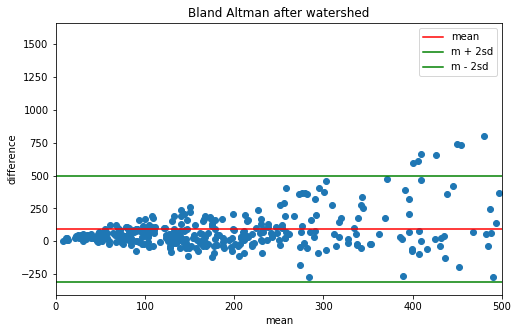

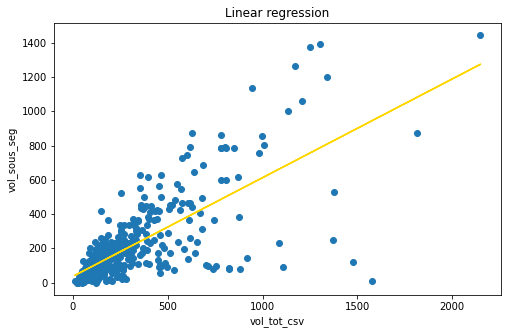

In [33]:
difference = []
mean = []
for i in range(len(vol_total_csv)):
    difference.append(vol_total_csv[i] - vol_sous_seg[i])
    subliste = []
    subliste.append(vol_total_csv[i])
    subliste.append(vol_sous_seg[i])
    mean.append(np.mean(subliste))


#plt.hist(difference, bins = 'fd')


f = plt.figure(figsize=(8,5))
axes = plt.gca()
moy = np.mean(difference)
sd = np.std(difference)
plt.axhline(moy, c='r', label='mean')
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.scatter(mean, difference)
plt.xlim(0, 500)
plt.xlabel('mean')
plt.ylabel('difference')
plt.legend()
plt.title('Bland Altman after watershed')

from scipy import stats
slope, intercept, r_value , p_value , stderr = stats.linregress(vol_total_csv, vol_sous_seg)
print("slope :", slope)
print("intercept :", intercept)
print("coeff de correlation :", r_value)
print("p value :", p_value)
print("stderr :", stderr)

def regression(x, slope, intercept):
    y=[]
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_sous_seg)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='gold', label='linear regression')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_sous_seg')
plt.title('Linear regression')

In [4]:
#Diagramme Bland Altman 

csv_ahl_post_process= r'C:\Users\wendy\Documents\STAGE\ahl_post_process_tmtv_mindist_2cm_markers_suv.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [5]:
csv_data[0]

['53011101371012',
 '1.2.250.1.74.20140306150000.1000040424629',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.250.1.74.20140306150000.1000040424629_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.250.1.74.20140306150000.1000040424629_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/ber_gu_feb 24_2014_SK.csv',
 '268.45',
 '334.27000000000004',
 '65.82000000000005',
 '244.29598246177193',
 '-24.15401753822806',
 '<60',
 '45.377636454068124']

In [63]:
 
vol_total_csv = []
vol_binaire = []
vol_sous_seg = []
diff = []
for row in csv_data : 
    vol_total_csv.append(float(row[5]))
    vol_binaire.append(float(row[-1]))
    vol_sous_seg.append(float(row[8]))
    diff.append(abs(float(row[9])))

In [64]:
diff

[24.15401753822806,
 231.3394536674623,
 215.61661255841375,
 31.99800000000002,
 663.5980440878286,
 14.649966206740345,
 405.69149500328496,
 188.7508115645312,
 126.18325725711009,
 23.768914618250562,
 23.444679369592905,
 74.3711221056775,
 2.7500000000000284,
 109.73015653989273,
 30.036493611830053,
 96.44599999999997,
 89.78089996197377,
 60.984347964023186,
 216.87353228365566,
 183.84943133804245,
 183.67997982025145,
 416.068014202118,
 42.0617847832678,
 32.17916833100128,
 145.98926056002028,
 7.933999999999855,
 47.399887505179265,
 52.924000000000035,
 22.645330781371456,
 853.9540000000002,
 19.426067672696263,
 55.60157240158003,
 939.4520520401004,
 200.46052614835503,
 138.04982657195842,
 472.49286748113866,
 38.65535465950995,
 179.49923016439732,
 316.3182515914259,
 124.73406465530388]

In [65]:
pourcent = []
for i in range(len(diff)):
    pourcent.append((diff[i] / vol_total_csv[i] )* 100)


In [66]:
pourcent

[8.997585225639062,
 17.758732280181032,
 34.784727609204296,
 16.566399171628277,
 89.59913102194464,
 6.286999487915349,
 81.62478270558226,
 51.96597422072882,
 22.34795481237449,
 15.799597592562192,
 8.627931906522248,
 42.02470594206786,
 1.4629994148002492,
 11.011003616466082,
 7.582483935028918,
 22.56627436299398,
 36.42227178984737,
 20.839375329422904,
 22.13876259773335,
 22.710357899306082,
 52.039885488511864,
 63.585905523446215,
 18.00204784218609,
 7.86392187952133,
 23.674573998219458,
 1.241919073334876,
 12.970989657438981,
 9.861002422209806,
 5.804113897214337,
 78.54834110580683,
 5.759114070942535,
 12.490525081788169,
 51.8306935041489,
 16.048910872844782,
 11.764741232632682,
 53.94431577950869,
 4.550311904451973,
 22.967375971082394,
 33.526757492625805,
 10.313117700753544]

In [70]:
#seuil critique : 
350/800 * 100 

43.75

In [72]:
cpt = 0
for item in pourcent : 
    if item < float(45) : 
        cpt += 1

In [73]:
cpt #sur 40 

32

In [9]:
#mask binaire 

In [45]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'vol_binary')

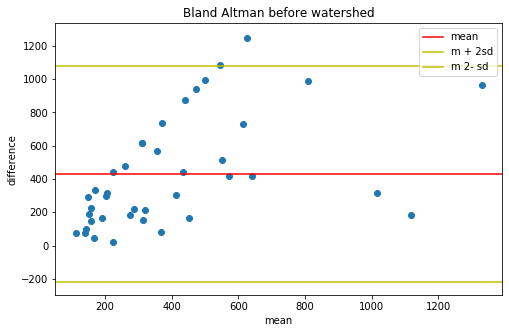

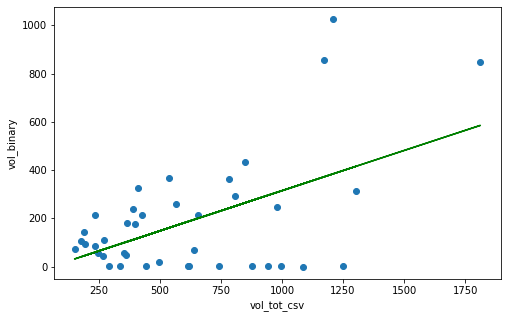

In [61]:
diff = []
moyenne = []
for i in range(len(vol_total_csv)) :
    diff.append(float(vol_total_csv[i]) - float(vol_binaire[i]))
    subliste = []
    subliste.append(float(vol_total_csv[i]))
    subliste.append(float(vol_binaire[i]))
    moyenne.append(np.mean(subliste))

f = plt.figure(figsize=(8,5))
axes = plt.gca()
mean = np.mean(diff)
sd = np.std(diff)
plt.axhline(mean, c = 'r', label = 'mean')
plt.axhline(mean + 2 * sd, c='y', label='m + 2sd')
plt.axhline(mean - 2 * sd, c='y', label='m 2- sd')
plt.scatter(moyenne, diff)
plt.xlabel("mean")
plt.ylabel('difference')
plt.legend()
plt.title("Bland Altman before watershed")


from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(vol_total_csv, vol_binaire)

def regression(x, slope, intercept):
    y = []
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_binaire)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='green')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_binary')



Text(0, 0.5, 'vol_binary')

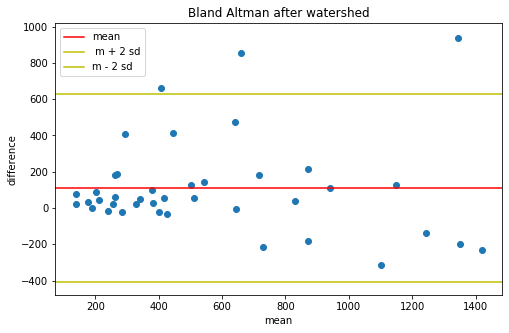

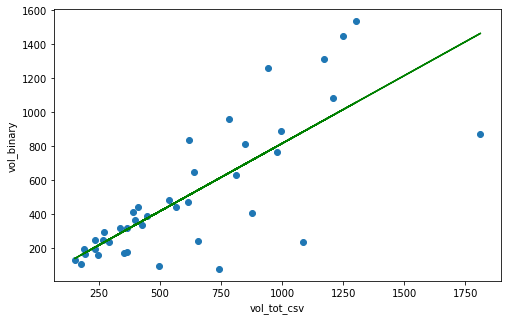

In [71]:
#tmtv sous seg 
diff = []
moyenne = []
for i in range(len(vol_total_csv)) :
    diff.append(float(vol_total_csv[i]) - float(vol_sous_seg[i]))
    subliste = []
    subliste.append(float(vol_total_csv[i]))
    subliste.append(float(vol_sous_seg[i]))
    moyenne.append(np.mean(subliste))

f = plt.figure(figsize=(8,5))
axes = plt.gca()
mean = np.mean(diff)
sd = np.std(diff)
plt.axhline(mean, c = 'r', label = 'mean')
plt.axhline( mean + 2 *sd, c='y',  label=' m + 2 sd')
plt.axhline(mean - 2 *sd, c='y', label='m - 2 sd')
plt.scatter(moyenne, diff)
plt.xlabel("mean")
plt.ylabel('difference')
plt.legend()
plt.title("Bland Altman after watershed")




from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(vol_total_csv, vol_sous_seg)

def regression(x, slope, intercept):
    y = []
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_sous_seg)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='green')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_binary')
